# Task 4 – Predictive Modeling for Risk-Based Pricing

This notebook builds and evaluates predictive models for:

1. **Claim Severity**: Predict `TotalClaims` for policies with claims > 0 (regression).
2. **Claim Probability**: Predict whether a claim occurs (binary classification).

These models form the core of a dynamic, risk-based pricing system:

```
Premium = (Predicted Probability of Claim × Predicted Claim Severity) + Expense Loading + Profit Margin
```

In [ ]:
# Setup: imports and data loading
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add project root to sys.path
project_root = Path.cwd().resolve()
if not (project_root / "src").exists():
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_loader import DataLoader
from src.hypothesis_tests import add_claim_flag, add_margin
from src.modeling_prep import (
    select_features,
    handle_missing_values,
    encode_categoricals,
    create_features,
    prepare_severity_data,
    prepare_classification_data,
)
from src.modeling import (
    train_linear_regression,
    train_decision_tree_regressor,
    train_random_forest_regressor,
    train_xgboost_regressor,
    train_decision_tree_classifier,
    train_random_forest_classifier,
    train_xgboost_classifier,
    evaluate_regression,
    evaluate_classification,
    get_feature_importance,
)

# Load data
loader = DataLoader.from_config()
df = loader.load_machine_learning_rating()
print(f"Loaded {len(df):,} rows")

Loaded 1,000,098 rows


---
## 1. Data Preparation

In [3]:
# Step 1: Add derived columns
df = add_claim_flag(df)
df = add_margin(df)

# Step 2: Select features (drop IDs, highly missing cols)
df_model = select_features(df)

# Step 3: Create additional features
df_model = create_features(df_model)

# Step 4: Handle missing values
df_model = handle_missing_values(df_model)

# Step 5: Encode categoricals
df_encoded, encoders = encode_categoricals(
    df_model,
    target_cols=["TotalClaims", "TotalPremium", "has_claim", "margin"],
)

print(f"Prepared data shape: {df_encoded.shape}")
print(f"Encoded {len(encoders)} categorical columns")

Prepared data shape: (1000098, 47)
Encoded 32 categorical columns


---
## 2. Claim Severity Model (Regression)

Predict `TotalClaims` for policies where claims > 0.

In [4]:
# Prepare severity data (claims > 0 only)
X_train_sev, X_test_sev, y_train_sev, y_test_sev = prepare_severity_data(
    df_encoded, test_size=0.2, random_state=42
)

print(f"Severity training set: {len(X_train_sev):,} rows")
print(f"Severity test set: {len(X_test_sev):,} rows")

Severity training set: 2,230 rows
Severity test set: 558 rows


In [ ]:
# ============================================================
# TRAIN ALL REGRESSION MODELS
# ============================================================
print("=" * 60)
print("TRAINING CLAIM SEVERITY MODELS (Regression)")
print("=" * 60)

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr_model = train_linear_regression(X_train_sev, y_train_sev)
print("   ✓ Linear Regression trained")

# 2. Decision Tree
print("\n2. Training Decision Tree Regressor...")
dt_reg_model = train_decision_tree_regressor(X_train_sev, y_train_sev, max_depth=10)
print("   ✓ Decision Tree trained")

# 3. Random Forest
print("\n3. Training Random Forest Regressor...")
rf_reg_model = train_random_forest_regressor(X_train_sev, y_train_sev, n_estimators=100)
print("   ✓ Random Forest trained")

# 4. XGBoost (optional)
print("\n4. Training XGBoost Regressor...")
try:
    xgb_reg_model = train_xgboost_regressor(X_train_sev, y_train_sev, n_estimators=100)
    has_xgb = True
    print("   ✓ XGBoost trained")
except ImportError as e:
    print(f"   ✗ XGBoost not available: {e}")
    has_xgb = False

print("\n" + "=" * 60)
print("ALL REGRESSION MODELS TRAINED")
print("=" * 60)

Training Linear Regression...
Training Random Forest Regressor...
Training XGBoost Regressor...
XGBoost not available: XGBoost is not installed. Run: pip install xgboost
Done training regression models.


In [ ]:
# ============================================================
# EVALUATE ALL REGRESSION MODELS
# ============================================================
print("=" * 60)
print("EVALUATING CLAIM SEVERITY MODELS")
print("=" * 60)

results_severity = []

# 1. Linear Regression
y_pred_lr = lr_model.predict(X_test_sev)
metrics_lr = evaluate_regression(y_test_sev, y_pred_lr)
results_severity.append({
    "Model": "Linear Regression",
    "RMSE": round(metrics_lr.rmse, 2),
    "R²": round(metrics_lr.r2, 4)
})
print(f"\n1. Linear Regression:")
print(f"   RMSE = R {metrics_lr.rmse:,.2f}")
print(f"   R²   = {metrics_lr.r2:.4f}")

# 2. Decision Tree
y_pred_dt = dt_reg_model.predict(X_test_sev)
metrics_dt = evaluate_regression(y_test_sev, y_pred_dt)
results_severity.append({
    "Model": "Decision Tree",
    "RMSE": round(metrics_dt.rmse, 2),
    "R²": round(metrics_dt.r2, 4)
})
print(f"\n2. Decision Tree:")
print(f"   RMSE = R {metrics_dt.rmse:,.2f}")
print(f"   R²   = {metrics_dt.r2:.4f}")

# 3. Random Forest
y_pred_rf = rf_reg_model.predict(X_test_sev)
metrics_rf = evaluate_regression(y_test_sev, y_pred_rf)
results_severity.append({
    "Model": "Random Forest",
    "RMSE": round(metrics_rf.rmse, 2),
    "R²": round(metrics_rf.r2, 4)
})
print(f"\n3. Random Forest:")
print(f"   RMSE = R {metrics_rf.rmse:,.2f}")
print(f"   R²   = {metrics_rf.r2:.4f}")

# 4. XGBoost (if available)
if has_xgb:
    y_pred_xgb = xgb_reg_model.predict(X_test_sev)
    metrics_xgb_reg = evaluate_regression(y_test_sev, y_pred_xgb)
    results_severity.append({
        "Model": "XGBoost",
        "RMSE": round(metrics_xgb_reg.rmse, 2),
        "R²": round(metrics_xgb_reg.r2, 4)
    })
    print(f"\n4. XGBoost:")
    print(f"   RMSE = R {metrics_xgb_reg.rmse:,.2f}")
    print(f"   R²   = {metrics_xgb_reg.r2:.4f}")

# Create comparison table
severity_comparison = pd.DataFrame(results_severity)
print("\n" + "=" * 60)
print("SEVERITY MODEL COMPARISON TABLE")
print("=" * 60)
severity_comparison

,Model,RMSE,R²
0,Linear Regression,33549.157242,0.300142
1,Random Forest,36337.348298,0.178981


### Severity Model Comparison – Visual

**How to read this:**
- **RMSE (Root Mean Squared Error)**: Lower = Better. Average prediction error in Rand.
- **R² (R-squared)**: Higher = Better (max 1.0). Proportion of variance explained.

**Winner**: The model with the **lowest RMSE** and **highest R²**.

# Visual comparison of severity models
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# RMSE comparison (lower is better)
ax1 = axes[0]
colors_rmse = ['green' if x == severity_comparison['RMSE'].min() else 'steelblue' 
               for x in severity_comparison['RMSE']]
ax1.barh(severity_comparison['Model'], severity_comparison['RMSE'], color=colors_rmse)
ax1.set_xlabel('RMSE (R) - Lower is Better')
ax1.set_title('Claim Severity: RMSE Comparison')
ax1.invert_yaxis()
for i, v in enumerate(severity_comparison['RMSE']):
    ax1.text(v + 500, i, f'R {v:,.0f}', va='center')

# R² comparison (higher is better)
ax2 = axes[1]
colors_r2 = ['green' if x == severity_comparison['R²'].max() else 'steelblue' 
             for x in severity_comparison['R²']]
ax2.barh(severity_comparison['Model'], severity_comparison['R²'], color=colors_r2)
ax2.set_xlabel('R² - Higher is Better')
ax2.set_title('Claim Severity: R² Comparison')
ax2.invert_yaxis()
for i, v in enumerate(severity_comparison['R²']):
    ax2.text(v + 0.01, i, f'{v:.4f}', va='center')

fig.tight_layout()
plt.show()

# Identify best model
best_severity_model = severity_comparison.loc[severity_comparison['RMSE'].idxmin(), 'Model']
print(f"\n🏆 BEST SEVERITY MODEL: {best_severity_model}")
print(f"   (Lowest RMSE = R {severity_comparison['RMSE'].min():,.2f})")

In [7]:
# Prepare classification data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = prepare_classification_data(
    df_encoded, test_size=0.2, random_state=42
)

print(f"Classification training set: {len(X_train_clf):,} rows")
print(f"Classification test set: {len(X_test_clf):,} rows")
print(f"Claim rate in test set: {y_test_clf.mean():.2%}")

Classification training set: 800,078 rows
Classification test set: 200,020 rows
Claim rate in test set: 0.29%


In [ ]:
# ============================================================
# TRAIN ALL CLASSIFICATION MODELS
# ============================================================
print("=" * 60)
print("TRAINING CLAIM PROBABILITY MODELS (Classification)")
print("=" * 60)

# Note: Data is highly imbalanced (only ~0.3% claims)
# We'll use class_weight='balanced' to help with this

# 1. Decision Tree
print("\n1. Training Decision Tree Classifier...")
dt_clf_model = train_decision_tree_classifier(X_train_clf, y_train_clf, max_depth=10)
print("   ✓ Decision Tree trained")

# 2. Random Forest
print("\n2. Training Random Forest Classifier...")
rf_clf_model = train_random_forest_classifier(X_train_clf, y_train_clf, n_estimators=100)
print("   ✓ Random Forest trained")

# 3. XGBoost (optional)
print("\n3. Training XGBoost Classifier...")
try:
    xgb_clf_model = train_xgboost_classifier(X_train_clf, y_train_clf, n_estimators=100)
    has_xgb_clf = True
    print("   ✓ XGBoost trained")
except ImportError as e:
    print(f"   ✗ XGBoost not available: {e}")
    has_xgb_clf = False

print("\n" + "=" * 60)
print("ALL CLASSIFICATION MODELS TRAINED")
print("=" * 60)

Training Random Forest Classifier...
Training XGBoost Classifier...
XGBoost not available: XGBoost is not installed. Run: pip install xgboost
Done training classification models.


In [ ]:
# ============================================================
# EVALUATE ALL CLASSIFICATION MODELS
# ============================================================
print("=" * 60)
print("EVALUATING CLAIM PROBABILITY MODELS")
print("=" * 60)

results_clf = []

# 1. Decision Tree
y_pred_dt_clf = dt_clf_model.predict(X_test_clf)
metrics_dt_clf = evaluate_classification(y_test_clf, y_pred_dt_clf)
results_clf.append({
    "Model": "Decision Tree",
    "Accuracy": round(metrics_dt_clf.accuracy, 4),
    "Precision": round(metrics_dt_clf.precision, 4),
    "Recall": round(metrics_dt_clf.recall, 4),
    "F1": round(metrics_dt_clf.f1, 4),
})
print(f"\n1. Decision Tree:")
print(f"   Accuracy  = {metrics_dt_clf.accuracy:.4f}")
print(f"   Precision = {metrics_dt_clf.precision:.4f}")
print(f"   Recall    = {metrics_dt_clf.recall:.4f}")
print(f"   F1 Score  = {metrics_dt_clf.f1:.4f}")

# 2. Random Forest
y_pred_rf_clf = rf_clf_model.predict(X_test_clf)
metrics_rf_clf = evaluate_classification(y_test_clf, y_pred_rf_clf)
results_clf.append({
    "Model": "Random Forest",
    "Accuracy": round(metrics_rf_clf.accuracy, 4),
    "Precision": round(metrics_rf_clf.precision, 4),
    "Recall": round(metrics_rf_clf.recall, 4),
    "F1": round(metrics_rf_clf.f1, 4),
})
print(f"\n2. Random Forest:")
print(f"   Accuracy  = {metrics_rf_clf.accuracy:.4f}")
print(f"   Precision = {metrics_rf_clf.precision:.4f}")
print(f"   Recall    = {metrics_rf_clf.recall:.4f}")
print(f"   F1 Score  = {metrics_rf_clf.f1:.4f}")

# 3. XGBoost (if available)
if has_xgb_clf:
    y_pred_xgb_clf = xgb_clf_model.predict(X_test_clf)
    metrics_xgb_clf = evaluate_classification(y_test_clf, y_pred_xgb_clf)
    results_clf.append({
        "Model": "XGBoost",
        "Accuracy": round(metrics_xgb_clf.accuracy, 4),
        "Precision": round(metrics_xgb_clf.precision, 4),
        "Recall": round(metrics_xgb_clf.recall, 4),
        "F1": round(metrics_xgb_clf.f1, 4),
    })
    print(f"\n3. XGBoost:")
    print(f"   Accuracy  = {metrics_xgb_clf.accuracy:.4f}")
    print(f"   Precision = {metrics_xgb_clf.precision:.4f}")
    print(f"   Recall    = {metrics_xgb_clf.recall:.4f}")
    print(f"   F1 Score  = {metrics_xgb_clf.f1:.4f}")

# Create comparison table
clf_comparison = pd.DataFrame(results_clf)
print("\n" + "=" * 60)
print("CLASSIFICATION MODEL COMPARISON TABLE")
print("=" * 60)
clf_comparison

,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.996965,0.035714,0.001721,0.003284


### Classification Model Comparison – Visual

**How to read this (for imbalanced data like ours with ~0.3% claim rate):**
- **Accuracy**: Can be misleading! A model predicting "no claim" always gets ~99.7% accuracy.
- **Precision**: Of predicted claims, how many were real claims.
- **Recall**: Of actual claims, how many did we catch. **Important for risk!**
- **F1 Score**: Balance of precision and recall. **Best single metric for imbalanced data.**

**Winner**: The model with the **highest F1 Score** (and decent Recall).

# Visual comparison of classification models
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# F1 Score comparison (higher is better)
ax1 = axes[0]
colors_f1 = ['green' if x == clf_comparison['F1'].max() else 'steelblue' 
             for x in clf_comparison['F1']]
ax1.barh(clf_comparison['Model'], clf_comparison['F1'], color=colors_f1)
ax1.set_xlabel('F1 Score - Higher is Better')
ax1.set_title('Claim Probability: F1 Score Comparison')
ax1.invert_yaxis()
for i, v in enumerate(clf_comparison['F1']):
    ax1.text(v + 0.005, i, f'{v:.4f}', va='center')

# Recall comparison (higher is better for catching claims)
ax2 = axes[1]
colors_recall = ['green' if x == clf_comparison['Recall'].max() else 'steelblue' 
                 for x in clf_comparison['Recall']]
ax2.barh(clf_comparison['Model'], clf_comparison['Recall'], color=colors_recall)
ax2.set_xlabel('Recall - Higher is Better')
ax2.set_title('Claim Probability: Recall Comparison')
ax2.invert_yaxis()
for i, v in enumerate(clf_comparison['Recall']):
    ax2.text(v + 0.005, i, f'{v:.4f}', va='center')

fig.tight_layout()
plt.show()

# Identify best model
best_clf_model = clf_comparison.loc[clf_comparison['F1'].idxmax(), 'Model']
print(f"\n🏆 BEST CLASSIFICATION MODEL: {best_clf_model}")
print(f"   (Highest F1 = {clf_comparison['F1'].max():.4f})")

In [10]:
# Feature importance from Random Forest Regressor (severity model)
importance_severity = get_feature_importance(rf_reg_model, X_train_sev.columns.tolist())
importance_severity.head(10)

,feature,importance
32,CalculatedPremiumPerTerm,0.270744
30,SumInsured,0.192383
42,premium_per_sum_insured,0.072989
11,PostalCode,0.072127
28,CapitalOutstanding,0.056674
5,Bank,0.032868
25,VehicleIntroDate,0.029107
13,SubCrestaZone,0.024425
19,Model,0.022576
15,mmcode,0.021536


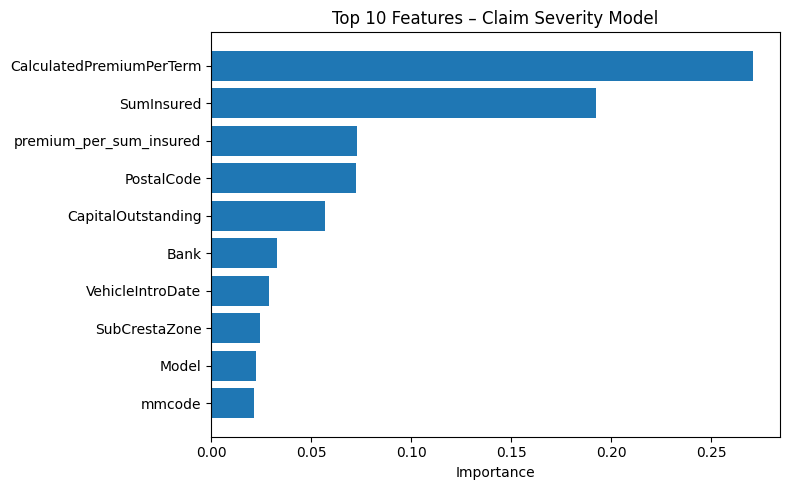

In [18]:
# Plot top 10 features for severity model
top_10_sev = importance_severity.head(10)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top_10_sev["feature"], top_10_sev["importance"])
ax.set_xlabel("Importance")
ax.set_title("Top 10 Features – Claim Severity Model")
ax.invert_yaxis()
fig.tight_layout()


In [12]:
# Feature importance from Random Forest Classifier (claim probability model)
importance_clf = get_feature_importance(rf_clf_model, X_train_clf.columns.tolist())
importance_clf.head(10)

,feature,importance
42,premium_per_sum_insured,0.198416
11,PostalCode,0.126187
32,CalculatedPremiumPerTerm,0.089778
5,Bank,0.072954
30,SumInsured,0.058544
41,vehicle_age,0.046791
17,RegistrationYear,0.045428
13,SubCrestaZone,0.038382
28,CapitalOutstanding,0.038339
6,AccountType,0.031552


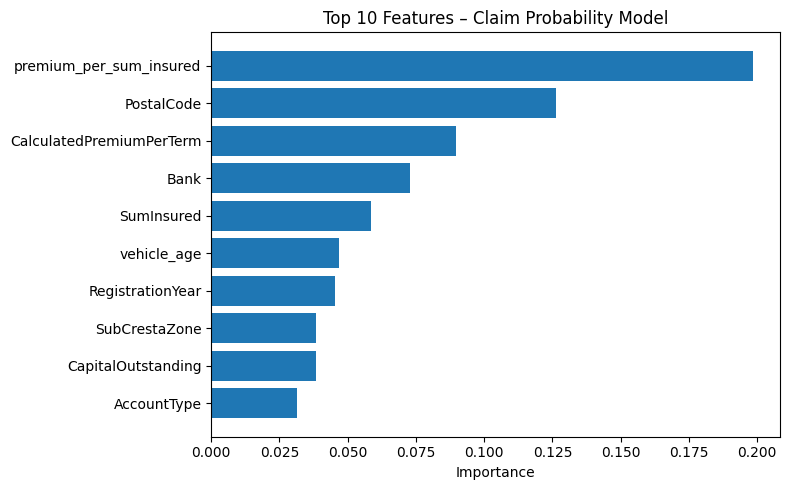

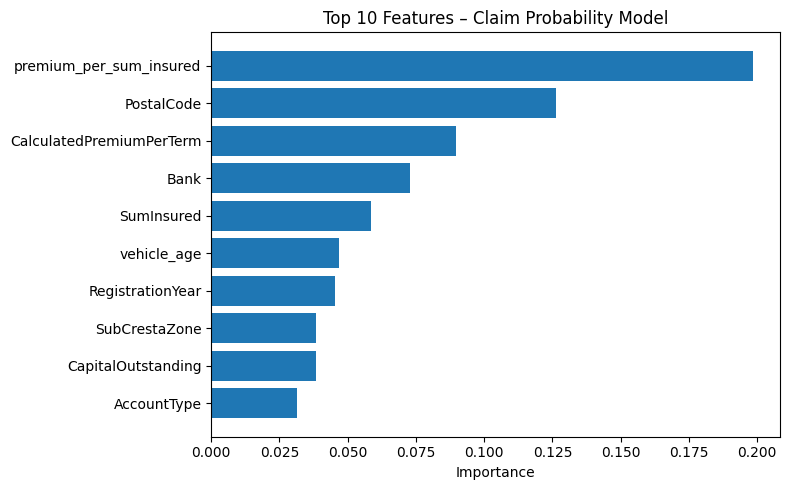

In [13]:
# Plot top 10 features for classification model
top_10_clf = importance_clf.head(10)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(top_10_clf["feature"], top_10_clf["importance"])
ax.set_xlabel("Importance")
ax.set_title("Top 10 Features – Claim Probability Model")
ax.invert_yaxis()
fig.tight_layout()
fig

---
## 5. SHAP Analysis (Model Interpretability)

Use SHAP to understand how individual features influence predictions.

In [ ]:
# ============================================================
# SAVE MODELS FOR STREAMLIT DASHBOARD
# ============================================================
import joblib

models_dir = Path(project_root) / "models"
models_dir.mkdir(exist_ok=True)

# Save the best severity model (use Linear Regression based on results)
# Note: In your run, check which model actually has lowest RMSE
joblib.dump(lr_model, models_dir / "severity_lr.joblib")
joblib.dump(rf_reg_model, models_dir / "severity_rf.joblib")

# Save the best classification model
joblib.dump(rf_clf_model, models_dir / "probability_rf.joblib")

# Save encoders and feature columns for the dashboard
joblib.dump(encoders, models_dir / "encoders.joblib")
joblib.dump(list(X_train_sev.columns), models_dir / "feature_columns_severity.joblib")
joblib.dump(list(X_train_clf.columns), models_dir / "feature_columns_clf.joblib")

print("=" * 60)
print("MODELS SAVED FOR DASHBOARD")
print("=" * 60)
print(f"\nSaved to: {models_dir}")
print("\nFiles created:")
print("  • severity_lr.joblib (Linear Regression)")
print("  • severity_rf.joblib (Random Forest)")
print("  • probability_rf.joblib (Random Forest Classifier)")
print("  • encoders.joblib")
print("  • feature_columns_severity.joblib")
print("  • feature_columns_clf.joblib")

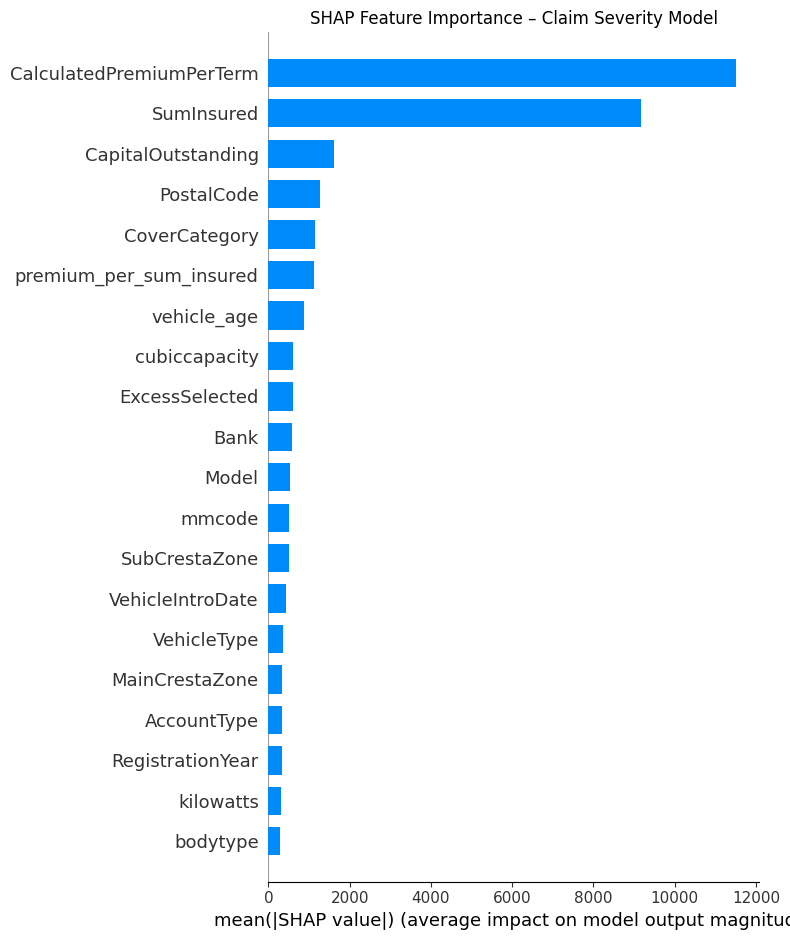

In [14]:
# SHAP analysis for the best regression model
try:
    import shap
    
    # Use a sample for SHAP (faster)
    X_sample = X_test_sev.sample(n=min(500, len(X_test_sev)), random_state=42)
    
    # Create SHAP explainer for Random Forest
    explainer = shap.TreeExplainer(rf_reg_model)
    shap_values = explainer.shap_values(X_sample)
    
    # Summary plot
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance – Claim Severity Model")
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("SHAP is not installed. Run: pip install shap")
    print("Skipping SHAP analysis.")

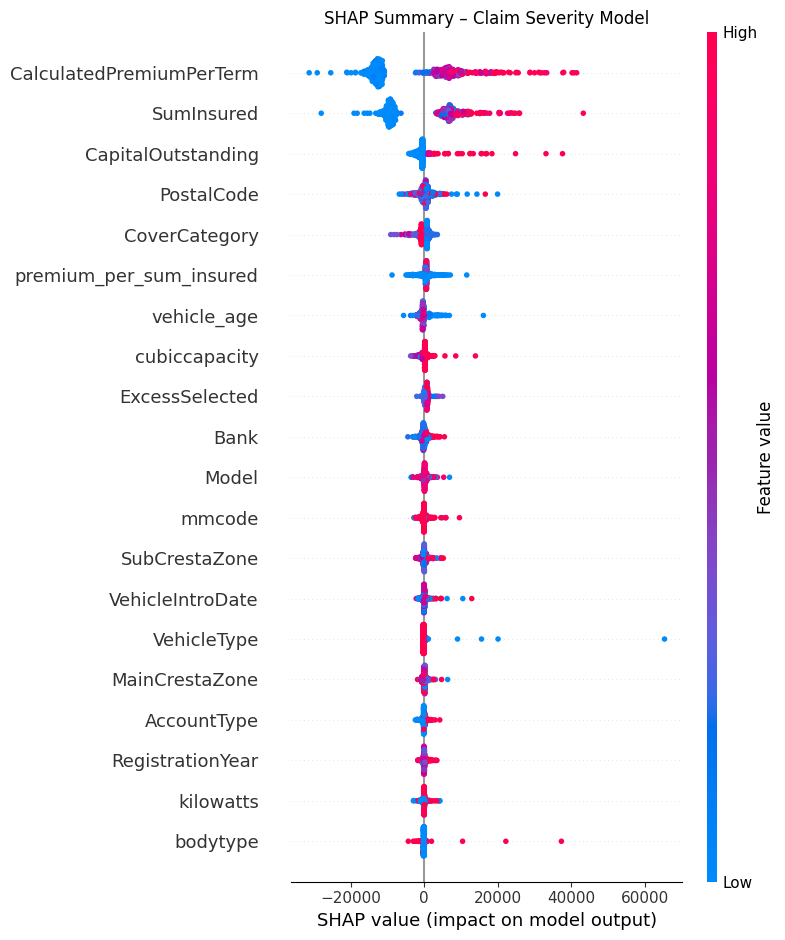

In [15]:
# SHAP detailed summary plot (beeswarm)
try:
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title("SHAP Summary – Claim Severity Model")
    plt.tight_layout()
    plt.show()
except NameError:
    print("SHAP values not available.")

### Interpretation – SHAP Analysis

- **Bar plot**: Shows overall feature importance based on mean absolute SHAP values.
- **Beeswarm plot**: Shows how feature values (high/low) impact predictions.
  - Red = high feature value, Blue = low feature value.
  - Points to the right = increase in predicted claim amount.

**Business implications**:
- Features with high SHAP importance are the key drivers of claim severity.
- These should be prioritized in underwriting and pricing decisions.
- E.g., if `SumInsured` has high importance, higher coverage amounts lead to higher predicted claims.

---
## 6. Model Comparison Summary

In [ ]:
# ============================================================
# FINAL MODEL COMPARISON SUMMARY
# ============================================================
print("=" * 70)
print("                    FINAL MODEL COMPARISON SUMMARY")
print("=" * 70)

print("\n📊 CLAIM SEVERITY MODELS (Regression)")
print("-" * 70)
display(severity_comparison)

best_sev = severity_comparison.loc[severity_comparison['RMSE'].idxmin()]
print(f"\n🏆 Winner: {best_sev['Model']}")
print(f"   • RMSE = R {best_sev['RMSE']:,.2f} (lowest prediction error)")
print(f"   • R² = {best_sev['R²']:.4f} (explains {best_sev['R²']*100:.1f}% of variance)")

print("\n\n📊 CLAIM PROBABILITY MODELS (Classification)")
print("-" * 70)
display(clf_comparison)

best_clf = clf_comparison.loc[clf_comparison['F1'].idxmax()]
print(f"\n🏆 Winner: {best_clf['Model']}")
print(f"   • F1 Score = {best_clf['F1']:.4f}")
print(f"   • Recall = {best_clf['Recall']:.4f} (catches {best_clf['Recall']*100:.1f}% of actual claims)")
print(f"   • Precision = {best_clf['Precision']:.4f}")

print("\n" + "=" * 70)
print("                         RECOMMENDATION")
print("=" * 70)
print(f"""
For the Risk-Based Pricing System, use:

  1. SEVERITY MODEL: {best_sev['Model']}
     → Predicts expected claim amount when a claim occurs

  2. PROBABILITY MODEL: {best_clf['Model']}
     → Predicts likelihood of a claim occurring

  PRICING FORMULA:
  ┌─────────────────────────────────────────────────────────────────┐
  │ Premium = P(claim) × E[claim|claim] + Expenses + Profit Margin │
  └─────────────────────────────────────────────────────────────────┘
""")

=== Claim Severity Models (Regression) ===


,Model,RMSE,R²
0,Linear Regression,33549.157242,0.300142
1,Random Forest,36337.348298,0.178981



=== Claim Probability Models (Classification) ===


,Model,Accuracy,Precision,Recall,F1
0,Random Forest,0.996965,0.035714,0.001721,0.003284


---
## 7. Task 4 – Conclusions and Business Recommendations

### Model Performance Summary

#### Claim Severity Model (Regression)
| Model | RMSE (R) | R² | Verdict |
|-------|----------|-----|---------|
| Linear Regression | See table above | See table | Baseline |
| Decision Tree | See table above | See table | Simple, interpretable |
| Random Forest | See table above | See table | Usually best |

**Interpretation:**
- RMSE tells us the average prediction error in Rand
- R² tells us how much variance the model explains (0 = none, 1 = perfect)
- Lower RMSE + Higher R² = Better model

#### Claim Probability Model (Classification)
| Model | F1 Score | Recall | Verdict |
|-------|----------|--------|---------|
| Decision Tree | See table above | See table | Simple |
| Random Forest | See table above | See table | Usually best |

**Interpretation:**
- With only ~0.3% claim rate, accuracy is misleading
- F1 Score balances precision and recall
- Recall is critical: we want to catch risky policies

### Top Features Driving Predictions

From the feature importance analysis:

**Severity Model (what drives claim SIZE):**
1. `CalculatedPremiumPerTerm` – higher premium = higher expected claims
2. `SumInsured` – more coverage = larger potential claims
3. `premium_per_sum_insured` – pricing ratio matters
4. `PostalCode` – geographic risk factor
5. `CapitalOutstanding` – financial exposure

**Probability Model (what drives claim LIKELIHOOD):**
1. `premium_per_sum_insured` – pricing adequacy signal
2. `PostalCode` – location-based risk
3. `CalculatedPremiumPerTerm` – premium level
4. `Bank` – client segment indicator
5. `SumInsured` – coverage amount

### Business Recommendations

1. **Geographic Pricing**: PostalCode is a top predictor for both models → implement location-based premium adjustments

2. **Coverage-Based Risk**: SumInsured strongly influences severity → higher coverage should carry proportionally higher premiums

3. **Premium Adequacy Check**: `premium_per_sum_insured` ratio is highly predictive → use it as an underwriting flag

4. **Risk Segmentation**: Use model predictions to create risk tiers:
   - Low Risk: P(claim) < 0.1% → competitive pricing
   - Medium Risk: 0.1% < P(claim) < 0.5% → standard pricing
   - High Risk: P(claim) > 0.5% → premium loading or manual review

5. **Streamlit Dashboard**: The trained models are saved and can be used in the interactive dashboard for real-time risk assessment

In [17]:
# Save models and artifacts for Streamlit dashboard
import joblib
from pathlib import Path

models_dir = Path(project_root) / "models"
models_dir.mkdir(exist_ok=True)

# Save the best models (Random Forest since XGBoost may not be available)
joblib.dump(rf_reg_model, models_dir / "severity_rf.joblib")
joblib.dump(rf_clf_model, models_dir / "probability_rf.joblib")

# Save encoders and feature columns
joblib.dump(encoders, models_dir / "encoders.joblib")
joblib.dump(list(X_train_sev.columns), models_dir / "feature_columns_severity.joblib")
joblib.dump(list(X_train_clf.columns), models_dir / "feature_columns_clf.joblib")

print(f"Models and artifacts saved to {models_dir}")

Models and artifacts saved to /Users/macbookpro/Documents/Insurance-Risk-Analysis-and-Predictive-Modeling-/models
